#**AI VIET NAM**
#**Transformer Applications**

#**Text Classification using BERT**

Một trong những mô hình pretrained đầu tiên cho dữ liệu văn bản dựa vào kiến trúc mô hình Transformer được ứng dụng cho các downstream task khác nhau đó là BERT. Trong phần này chúng ta sẽ fine tuning BERT cho bài toán phân loại trên bộ dữ liệu NTC-SCV dựa vào thư viện transformers của huggingface.


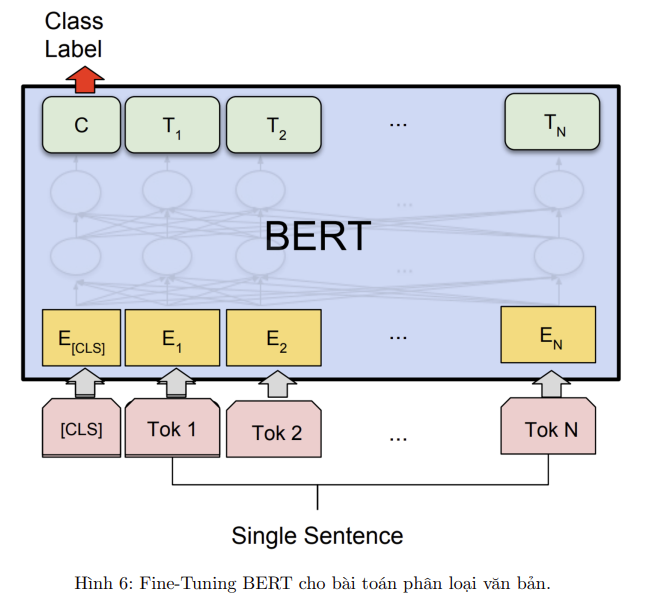

In [3]:
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install -q datasets accelerate evaluate

###**Load Dataset**

In [5]:
from datasets import load_dataset

ds = load_dataset('thainq107/ntc-scv')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/570 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/6.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
})

###**Preprocessing**

In [7]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
tokenizer.model_max_length

512

In [9]:
max_seq_length = 100
max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
    # Tokenize the texts

    result = tokenizer(
        examples["preprocessed_sentence"],
        padding="max_length",
        max_length=max_seq_length,
        truncation=True
    )
    result["label"] = examples['label']

    return result

In [10]:
# Running the preprocessing pipeline on all the datasets
processed_dataset = ds.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/30000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [11]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})

###**Modeling**

In [12]:
from transformers import AutoConfig, AutoModelForSequenceClassification

num_labels = 2

config = AutoConfig.from_pretrained(
    model_name,
    num_labels = num_labels,
    finetuning_task ="text-classification")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config = config)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


###**Metric**

In [14]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

###**Trainer**

In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='ntc-scv-distilbert-base-uncased',
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-15-1d8e69985dd1>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


###**Training**

In [16]:
import wandb
wandb.init(mode='disabled')

In [17]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.457601,0.794900
2,No log,0.425318,0.809600
3,No log,0.428539,0.807600
4,No log,0.394855,0.827900
5,0.430000,0.401297,0.831900
6,0.430000,0.382598,0.837000
7,0.430000,0.380731,0.841000
8,0.430000,0.414015,0.829600
9,0.308600,0.402661,0.837400
10,0.308600,0.396412,0.841900


TrainOutput(global_step=1180, training_loss=0.35411264775163037, metrics={'train_runtime': 605.3149, 'train_samples_per_second': 495.61, 'train_steps_per_second': 1.949, 'total_flos': 7761761640000000.0, 'train_loss': 0.35411264775163037, 'epoch': 10.0})

In [18]:
trainer.evaluate(processed_dataset["test"])

{'eval_loss': 0.361668199300766,
 'eval_accuracy': 0.8543,
 'eval_runtime': 6.6492,
 'eval_samples_per_second': 1503.946,
 'eval_steps_per_second': 6.016,
 'epoch': 10.0}

In [19]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="thainq107/ntc-scv-distilbert-base-uncased"
)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [20]:
classifier("quán ăn này ngon quá luôn nè")

[{'label': 'LABEL_1', 'score': 0.7825171947479248}]